# <center>Project ML: Music genre Classification</center>

## Corentin Pradier et Miguel Ángel Martínez Cámara

# Introduction

<div style="text-align: justify">
The word "music genre" is frequently used to group together types of songs that share a set of guidelines and according to their preferences, people make playlists based on certain music genres. Therefore, music genre classification plays a crucial role when it comes to creating recommendation systems for users. The objective of this proyect is to classify songs into various music genres based on their features using various machine learning approaches. To enhance the results, we will conduct appropriate feature engineering and data pre-processing techniques.

<div style="text-align: justify">
As for our dataset we used the Kaggle's dataset <a href ="https://www.kaggle.com/datasets/vicsuperman/prediction-of-music-genre"> "Prediction of music genre" </a>. We chose this dataset because of it's size, because each song is associate with a music genre and due to it's homogenity in the number of songs for each music genre.

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import seaborn as sns
import tensorflow as tf

from tensorflow import keras
from keras.utils import np_utils
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, roc_auc_score, RocCurveDisplay, roc_curve, auc
from sklearn.datasets import load_digits
from sklearn.preprocessing import MinMaxScaler
import scikitplot as skplt

# 1. Data preprocessing

<div style="text-align: justify">
Our dataset initially consists of 50005 songs (rows) with 15 features (columns) including the target class music_genre. Prior to the import of the .csv we have removed 2 columns that contained id information, like "track_mame" or "artist_name", not useful features for our classification model. Below is shown the 5 first songs with its features to help form an idea of the structure of the dataset.

In [ ]:
data = pd.read_csv("data_treated.csv", sep=";")

In [179]:
print(data.shape)
data.head()

(50005, 13)


,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,valence,music_genre
0,30.0,0.00479,0.566,106160.0,0.368,0.94600,7.0,0.1470,-11.116,1.0,0.0302,0.203,Electronic
1,29.0,0.00121,0.603,192000.0,0.995,0.02980,4.0,0.8740,-0.084,0.0,0.1080,0.189,Electronic
2,42.0,0.00403,0.654,182400.0,0.882,0.00000,1.0,0.5580,-4.718,1.0,0.0918,0.681,Electronic
3,36.0,0.18800,0.665,189619.0,0.807,0.00075,4.0,0.0954,-6.314,1.0,0.0375,0.647,Electronic
4,52.0,0.61900,0.690,289573.0,0.656,0.36400,9.0,0.1150,-10.460,1.0,0.0753,0.611,Electronic


<div style="text-align: justify">
We normalize the data so that the variables are of the same order of magnitude, avoiding that features with large range dominate over other features with smaller range. We do this before splitting in training and test datasets because with large amount of data we have it makes no difference doing it before. 

In [180]:
# Normalize the data
scaler = MinMaxScaler()
data_normalized = pd.DataFrame(scaler.fit_transform(data.iloc[:,:-1]), columns=data.iloc[:,:-1].columns, index=data.index)
data_normalized = pd.concat([data_normalized, data['music_genre']], axis=1) 

In [181]:
print(data_normalized.shape)
data_normalized.head()

(50005, 13)


,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,valence,music_genre
0,0.303030,0.004809,0.546632,0.023602,0.367867,0.949799,0.636364,0.138671,0.707423,1.0,0.008590,0.204637,Electronic
1,0.292929,0.001215,0.586572,0.042686,0.995993,0.029920,0.363636,0.872770,0.924631,0.0,0.093183,0.190524,Electronic
2,0.424242,0.004046,0.641623,0.040552,0.882790,0.000000,0.090909,0.553684,0.833392,1.0,0.075568,0.686492,Electronic
3,0.363636,0.188755,0.653497,0.042157,0.807655,0.000753,0.363636,0.086567,0.801969,1.0,0.016527,0.652218,Electronic
4,0.525253,0.621486,0.680484,0.064378,0.656384,0.365462,0.818182,0.106358,0.720339,1.0,0.057627,0.615927,Electronic


<div style="text-align: justify">
We look for NaN values in the dataset and remove them, ending up having 49396 songs. Then we randomise the rows and split the data in training (80%) and test (20%) set. Finally, we encode the categorical music_genre feature to have it in numerical format. 

In [182]:
data_non_nul = data_normalized.dropna()
data_random = data_non_nul.sample(frac=1,random_state=42).reset_index(drop=True)
data_t_categorical = data_random

In [183]:
data_t_categorical_train, data_t_categorical_test = train_test_split(data_t_categorical, test_size = 0.2)
data_t_categorical_train = data_t_categorical_train.reset_index(drop=True)
data_t_categorical_test = data_t_categorical_test.reset_index(drop=True)

In [184]:
genre_encoder = LabelEncoder()
genre_encoder.fit(data_t_categorical.iloc[:,-1])
genres_tags = genre_encoder.classes_

In [193]:
# New to fusion rap and hiphop
data_t_categorical_fusion = data_t_categorical.copy()
data_t_categorical_train_fusion = data_t_categorical_train.copy()
data_t_categorical_test_fusion = data_t_categorical_test.copy()
data_t_categorical_fusion["music_genre"] = data_t_categorical['music_genre'].replace(['Rap', 'Hip-Hop'], 'Rap and Hip-Hop')
data_t_categorical_train_fusion["music_genre"] = data_t_categorical_train['music_genre'].replace(['Rap', 'Hip-Hop'], 'Rap and Hip-Hop')
data_t_categorical_test_fusion["music_genre"] = data_t_categorical_test['music_genre'].replace(['Rap', 'Hip-Hop'], 'Rap and Hip-Hop')
genre_encoder_fusion = LabelEncoder()
genre_encoder_fusion.fit(data_t_categorical_fusion.iloc[:,-1])
genres_tags_fusion = genre_encoder_fusion.classes_

In [194]:
genres_tags_fusion

array(['Alternative', 'Anime', 'Blues', 'Classical', 'Country',
       'Electronic', 'Jazz', 'Rap and Hip-Hop', 'Rock'], dtype=object)

In [195]:
data_t_categorical_test.head()

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,valence,music_genre
0,0.676768,0.184739,0.870466,0.050274,0.534165,0.267068,0.181818,0.084043,0.745127,1.0,0.224747,0.847782,Hip-Hop
1,0.525253,0.010442,0.848877,0.088317,0.538172,0.561245,1.000000,0.045571,0.762552,0.0,0.098619,0.582661,Jazz
2,0.656566,0.073193,0.784111,0.034941,0.854740,0.000002,0.454545,0.170983,0.842666,1.0,0.032619,0.692540,Rap
3,0.494949,0.335341,0.406304,0.074946,0.452018,0.000846,0.454545,0.077782,0.774641,1.0,0.003697,0.404234,Alternative
4,0.636364,0.910643,0.503454,0.047239,0.234628,0.000004,0.818182,0.102319,0.649183,0.0,0.083505,0.380040,Alternative


In [196]:
data_t_categorical_test_fusion.head()

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,valence,music_genre
0,0.676768,0.184739,0.870466,0.050274,0.534165,0.267068,0.181818,0.084043,0.745127,1.0,0.224747,0.847782,Rap and Hip-Hop
1,0.525253,0.010442,0.848877,0.088317,0.538172,0.561245,1.000000,0.045571,0.762552,0.0,0.098619,0.582661,Jazz
2,0.656566,0.073193,0.784111,0.034941,0.854740,0.000002,0.454545,0.170983,0.842666,1.0,0.032619,0.692540,Rap and Hip-Hop
3,0.494949,0.335341,0.406304,0.074946,0.452018,0.000846,0.454545,0.077782,0.774641,1.0,0.003697,0.404234,Alternative
4,0.636364,0.910643,0.503454,0.047239,0.234628,0.000004,0.818182,0.102319,0.649183,0.0,0.083505,0.380040,Alternative


In [203]:
def transform_to_numerical(data_t_categorical):
    
    data_t_no_genre = data_t_categorical.iloc[:,0:-1]
    
    data_t_numerical = data_t_categorical.copy()
    
    data_t_numerical["music_genre"] = genre_encoder.fit_transform(data_t_categorical["music_genre"])

    return data_t_numerical, data_t_no_genre

In [198]:
def transform_to_numerical_f(data_t_categorical):
    
    data_t_no_genre = data_t_categorical.iloc[:,0:-1]
    
    data_t_numerical = data_t_categorical.copy()
    
    data_t_numerical["music_genre"] = genre_encoder_fusion.fit_transform(data_t_categorical["music_genre"])

    return data_t_numerical, data_t_no_genre

In [205]:
data_t_numerical_train, data_t_no_genre_train_fusion = transform_to_numerical(data_t_categorical_train)
data_t_numerical_test, data_t_no_genre_test_fusion = transform_to_numerical(data_t_categorical_test)
data_t_numerical, data_t_no_genre_fusion = transform_to_numerical(data_t_categorical)

In [206]:
# For fusion
data_t_numerical_train_fusion, data_t_no_genre_train = transform_to_numerical_f(data_t_categorical_train_fusion)
data_t_numerical_test_fusion, data_t_no_genre_test = transform_to_numerical_f(data_t_categorical_test_fusion)
data_t_numerical_fusion, data_t_no_genre = transform_to_numerical_f(data_t_categorical_fusion)

In [207]:
data_t_categorical_train_fusion

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,valence,music_genre
0,0.555556,0.032731,0.711788,0.044574,0.477063,0.000000,0.727273,0.210364,0.799508,0.0,0.169294,0.299395,Rap and Hip-Hop
1,0.474747,0.206827,0.707470,0.079155,0.682431,0.920683,0.363636,0.087880,0.722997,1.0,0.011308,0.513105,Jazz
2,0.383838,0.000047,0.540155,0.046835,0.966941,0.001295,0.454545,0.170983,0.906241,1.0,0.014135,0.471774,Alternative
3,0.373737,0.007249,0.579016,0.052738,0.882790,0.001918,0.909091,0.303263,0.783717,1.0,0.084484,0.752016,Blues
4,0.494949,0.012149,0.226036,0.086225,0.903828,0.000042,0.818182,0.088284,0.813959,1.0,0.166032,0.097480,Alternative
...,...,...,...,...,...,...,...,...,...,...,...,...,...
39511,0.656566,0.074096,0.490501,0.064005,0.720499,0.000000,0.909091,0.139681,0.824119,1.0,0.325867,0.481855,Rap and Hip-Hop
39512,0.565657,0.660643,0.785190,0.063732,0.517135,0.000011,0.818182,0.285087,0.674385,1.0,0.011852,0.892137,Rock
39513,0.404040,0.021787,0.488342,0.044298,0.852736,0.026104,0.363636,0.316389,0.836090,1.0,0.142112,0.174395,Electronic
39514,0.555556,0.043373,0.650259,0.046768,0.714488,0.000000,0.727273,0.101310,0.807620,0.0,0.163858,0.701613,Rap and Hip-Hop


In [208]:
data_t_categorical_train

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,valence,music_genre
0,0.555556,0.032731,0.711788,0.044574,0.477063,0.000000,0.727273,0.210364,0.799508,0.0,0.169294,0.299395,Rap
1,0.474747,0.206827,0.707470,0.079155,0.682431,0.920683,0.363636,0.087880,0.722997,1.0,0.011308,0.513105,Jazz
2,0.383838,0.000047,0.540155,0.046835,0.966941,0.001295,0.454545,0.170983,0.906241,1.0,0.014135,0.471774,Alternative
3,0.373737,0.007249,0.579016,0.052738,0.882790,0.001918,0.909091,0.303263,0.783717,1.0,0.084484,0.752016,Blues
4,0.494949,0.012149,0.226036,0.086225,0.903828,0.000042,0.818182,0.088284,0.813959,1.0,0.166032,0.097480,Alternative
...,...,...,...,...,...,...,...,...,...,...,...,...,...
39511,0.656566,0.074096,0.490501,0.064005,0.720499,0.000000,0.909091,0.139681,0.824119,1.0,0.325867,0.481855,Hip-Hop
39512,0.565657,0.660643,0.785190,0.063732,0.517135,0.000011,0.818182,0.285087,0.674385,1.0,0.011852,0.892137,Rock
39513,0.404040,0.021787,0.488342,0.044298,0.852736,0.026104,0.363636,0.316389,0.836090,1.0,0.142112,0.174395,Electronic
39514,0.555556,0.043373,0.650259,0.046768,0.714488,0.000000,0.727273,0.101310,0.807620,0.0,0.163858,0.701613,Rap


<div style="text-align: justify">
To show that we have correctly performed all the steps and below and there is correspondence between the dataframes in the 3 forms that we will use (with the target class categorical, with the target class numerical and without the target class), we can find below the 3 forms of train dataset as an illustrative example. Lastly, we also show the number of songs for each music genre in train and test set to ensure there is balance within the music genres.  

In [22]:
data_t_categorical_train.head()

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,valence,music_genre
0,0.555556,0.000163,0.254102,0.039787,0.789623,0.090763,0.363636,0.089798,0.816834,1.0,0.052300,0.517137,Rock
1,0.222222,0.969880,0.059801,0.016150,0.238636,0.926707,0.272727,0.096261,0.764796,1.0,0.009786,0.029940,Anime
2,0.535354,0.473896,0.699914,0.048238,0.716492,0.000000,0.818182,0.179062,0.820339,1.0,0.024030,0.311492,Country
3,0.232323,0.277108,0.688040,0.091019,0.388905,0.885542,0.272727,0.104339,0.655897,1.0,0.020550,0.595766,Electronic
4,0.585859,0.244980,0.598446,0.044390,0.380891,0.000041,0.545455,0.082831,0.638275,1.0,0.023703,0.508065,Country


In [23]:
data_t_numerical_train.head()

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,valence,music_genre
0,0.555556,0.000163,0.254102,0.039787,0.789623,0.090763,0.363636,0.089798,0.816834,1.0,0.052300,0.517137,9
1,0.222222,0.969880,0.059801,0.016150,0.238636,0.926707,0.272727,0.096261,0.764796,1.0,0.009786,0.029940,1
2,0.535354,0.473896,0.699914,0.048238,0.716492,0.000000,0.818182,0.179062,0.820339,1.0,0.024030,0.311492,4
3,0.232323,0.277108,0.688040,0.091019,0.388905,0.885542,0.272727,0.104339,0.655897,1.0,0.020550,0.595766,5
4,0.585859,0.244980,0.598446,0.044390,0.380891,0.000041,0.545455,0.082831,0.638275,1.0,0.023703,0.508065,4


In [24]:
data_t_no_genre_train.head()

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,valence
0,0.555556,0.000163,0.254102,0.039787,0.789623,0.090763,0.363636,0.089798,0.816834,1.0,0.052300,0.517137
1,0.222222,0.969880,0.059801,0.016150,0.238636,0.926707,0.272727,0.096261,0.764796,1.0,0.009786,0.029940
2,0.535354,0.473896,0.699914,0.048238,0.716492,0.000000,0.818182,0.179062,0.820339,1.0,0.024030,0.311492
3,0.232323,0.277108,0.688040,0.091019,0.388905,0.885542,0.272727,0.104339,0.655897,1.0,0.020550,0.595766
4,0.585859,0.244980,0.598446,0.044390,0.380891,0.000041,0.545455,0.082831,0.638275,1.0,0.023703,0.508065


In [151]:
print('train :\n', data_t_categorical_train.groupby("music_genre").size(), '\n\ntest :\n', data_t_categorical_test.groupby("music_genre").size()) 

train :
 music_genre
Alternative    3979
Anime          3954
Blues          3955
Classical      3990
Country        3977
Electronic     3968
Hip-Hop        3656
Jazz           4027
Rap            4007
Rock           4003
dtype: int64 

test :
 music_genre
Alternative    1019
Anime          1037
Blues           996
Classical       988
Country        1023
Electronic     1030
Hip-Hop         865
Jazz            963
Rap             991
Rock            968
dtype: int64


# 2. Exploratory data analysis

**Correlation Matrix of whole dataset**

First of all, we plot the correlation matrix of the datas. Thanks to this, we can see what features are correlated or not.

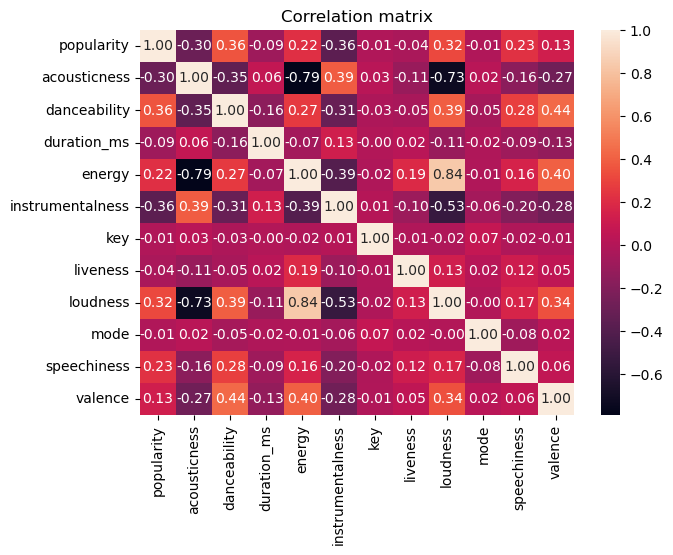

In [15]:
plt.figure(figsize = (7,5))
sns.heatmap(data_t_no_genre_train.corr(), annot = True, fmt = ".2f", cbar = True)
plt.xticks(rotation = 90)
plt.yticks(rotation = 0)
plt.title('Correlation matrix')
plt.show()

<div style="text-align: justify">
In the correlation matrix, the more the number in a case tends to 1 the more the features are correlated. It is the inverse for -1. So, the diagonal only contains one because each feature is correlate with itself. We can notice that some features are correlated with others as energy and loudness which are the two most related features. There is also danceability and valence. And some of them can be inversely correlated as loudness and acousticness or loudness and energy. Moreover, some of them are correlated with no other as key and mode.

<div style="text-align: justify">
To analyse the data, we plot the histogramms of the features for each genre (Appendix 1) and the genres for each feature. 

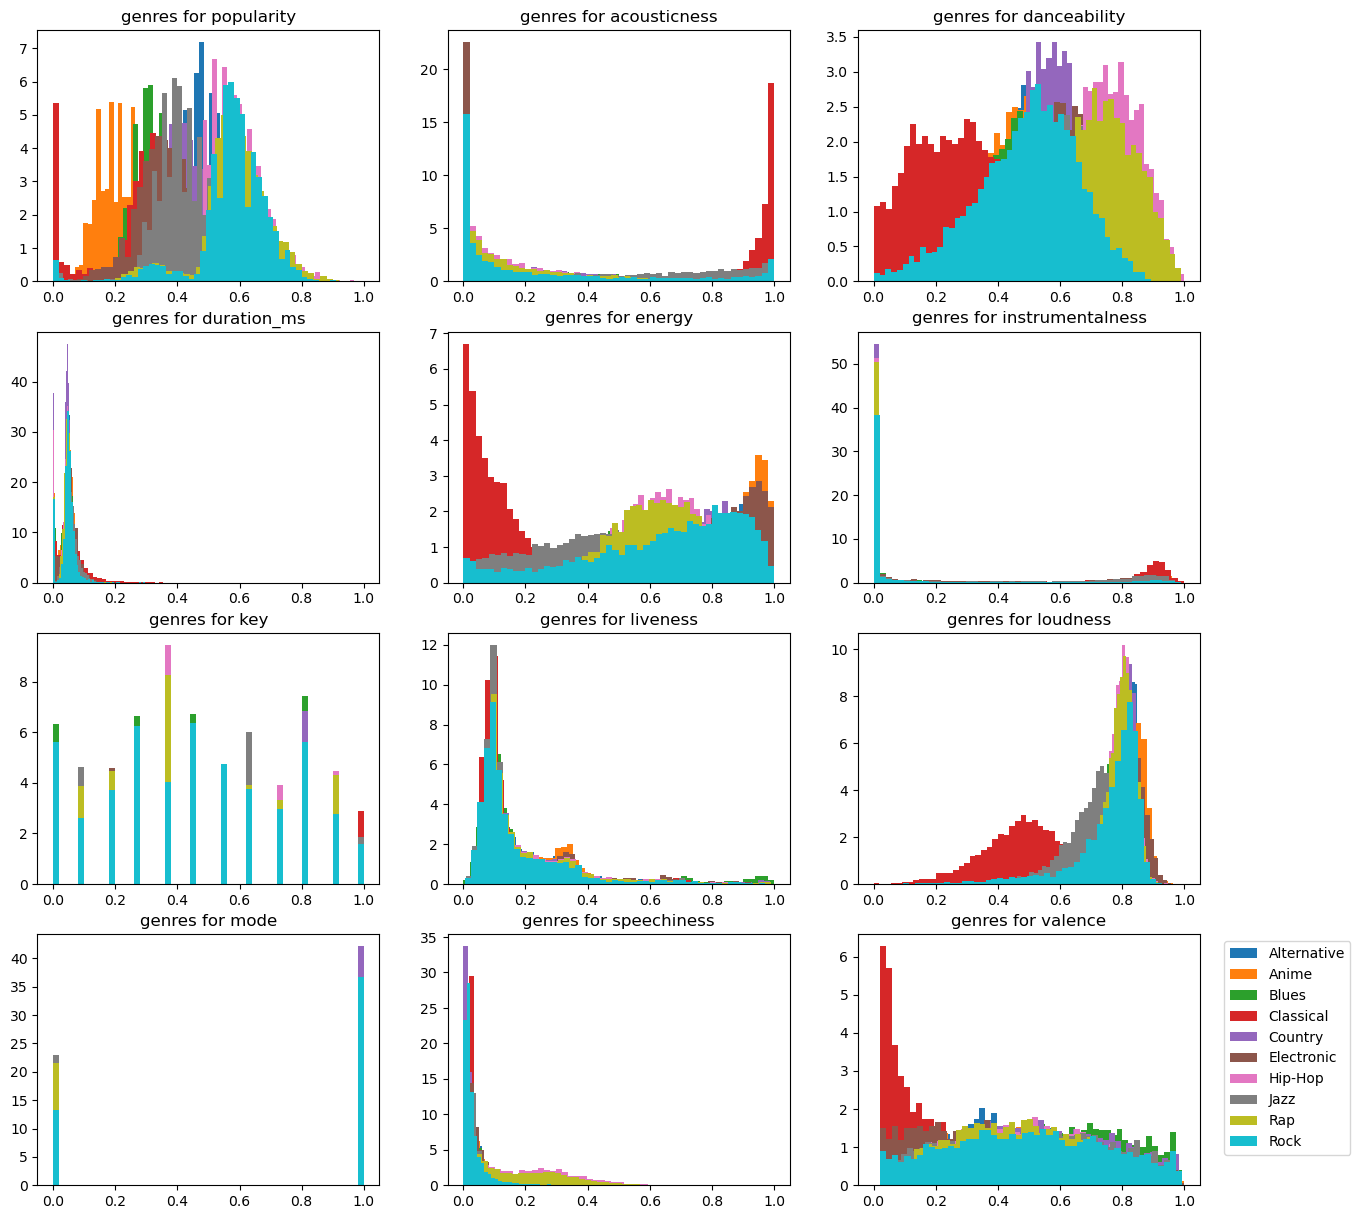

In [16]:
plt.figure(figsize=(15,15))
for i, feature in enumerate(data_t_no_genre.columns):
    plt.subplot(4,3,i+1)
    plt.title('genres for ' + feature) 
    for genre in genres_tags:
        dat_hist = data_t_categorical[feature]
        cond =  data_t_categorical['music_genre'].values == genre
        dat_hist = dat_hist[cond]
        plt.hist(dat_hist, bins = 50, density=True, label = genre)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

<div style="text-align: justify">
We notice that for the features "mode" and "key", the repartition for each genre seems arbitrary, and we believe they are not useful features for our model. Moreover, observing the "duration_ms" and "liveness" histograms we can see homogeneous distributions for all genres, indicating these features will not help our model to better differentiate genres. Despite our hypothesis of these features not contributing to a better classifcation model, we will keep them for the moment. 

### PCA - Dimensionality reduction

**We study how many principal components to keep without risking loosing too much information**

<div style="text-align: justify">
If we only had 3 features we could easily represent our data in a 3d plot and observe if the songs of the same music_genre are closers between them. Nonetheless, with PCA we can reduce dimensions to keep new ones that conserve the biggest variance and create a visualization in 3D or 4D. It is important to remove the discrete variables before permorfing the PCA, as they would have a bigger influence in the variance.

<div style="text-align: justify">
Initially we will perform PCA as many number of components as features to create a scree plot that shows how much variance is kept by each principal component. This will help us identify how many principal components we can keep without loosing too much explained variance.

<div style="text-align: justify">
    First of all, we have to remove the non continuous features to realize our PCA. The PCA has to be perform on continuous features. Without this, the final result will be split into as many parts as the discrete features can take values.  

In [17]:
data_t_no_genre_continuous = data_t_no_genre.drop(['key', 'mode'], axis='columns')

In [18]:
pca =  PCA(n_components = 10) # We remove key and mode so we have 10 columns
projected_data = pca.fit_transform(data_t_no_genre_continuous)
pca_variances = pca.explained_variance_ratio_

pca_explained_variances = pca.explained_variance_
pca_cumulative_variances = np.cumsum(pca_explained_variances) / np.sum(pca_explained_variances)

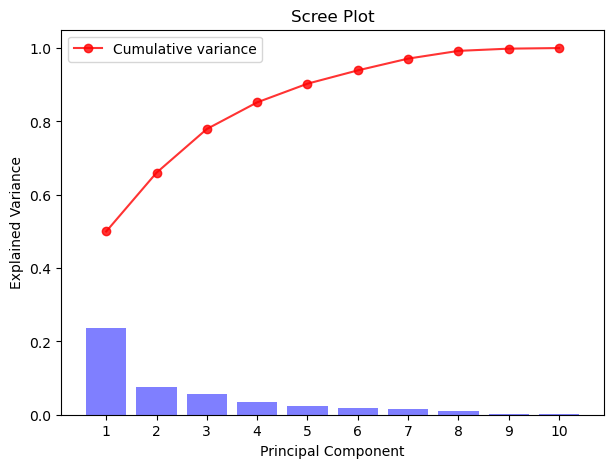

In [19]:
fig, ax = plt.subplots(figsize = (7,5))
ax.bar(np.arange(len(pca_explained_variances))+1, pca_explained_variances, color= "b", align = "center", alpha = 0.5)
ax.plot(np.arange(len(pca_cumulative_variances))+1, pca_cumulative_variances, color= "r", marker = "o", alpha = 0.8, label = "Cumulative variance")
ax.set_xlabel('Principal Component')
ax.set_ylabel('Explained Variance')
ax.set_title('Scree Plot')
x_units = np.arange(1,11,1)
ax.set_xticks(x_units)
plt.legend()
plt.show()

In [20]:
print(pca_cumulative_variances[2])

0.7792518889424095


Therefore only by selecting the first 3 principal components we keep 77.9 % of the total explained variance.

**We reduce the problem to a 3-dimensional problem with PCA**

In [21]:
pca = PCA(n_components = 3)
projected_data = pca.fit_transform(data_t_no_genre_continuous)

In [22]:
pca_var = pca.explained_variance_ratio_
print(f'PC 1 explains {pca_var[0]*100} % of variance')
print(f'PC 2 explains {pca_var[1]*100} % of variance')
print(f'PC 3 explains {pca_var[2]*100} % of variance')

PC 1 explains 49.97206105251065 % of variance
PC 2 explains 16.03279724870929 % of variance
PC 3 explains 11.920330593021038 % of variance


In [23]:
def plot_projection(x, c, ind1, ind2):
    fig, ax = plt.subplots(figsize=(9,6))
    # cmap=plt.cm.get_cmap('tab10')
    cmap=plt.cm.get_cmap('tab10', 10)
    sc = ax.scatter(x[:, ind1], x[:, ind2], c=c["music_genre"], 
                edgecolor='none', alpha=0.7, cmap=cmap, vmin = 0, s = 1)
    col = plt.colorbar(sc, ticks=np.linspace(0, 9, 10), alpha=1)
    col.ax.yaxis.set_major_formatter(ticker.FixedFormatter(genres_tags))
    ax.set_xlabel(f"Principal component {ind1+1}")
    ax.set_ylabel(f"Principal component {ind2+1}")
    plt.show()

In [24]:
def row_projection(x, c, ind00=0, ind01=1, ind10=0, ind11=2, ind20=1, ind21=2):
    fig, ax = plt.subplots(1, 3, figsize=(13,5))
    plt.gcf().subplots_adjust(left = 0.2, bottom = 0.2, right = 0.9, top = 0.9, wspace = 0.3, hspace = 0)
    cmap=plt.cm.get_cmap('tab10', 10)

    ax[0].scatter(x[:, ind00], x[:, ind01], c=c["music_genre"], edgecolor='none', alpha=0.7, cmap=cmap, vmin = 0, s = 1)
    ax[0].set_xlabel(f"Principal component {ind00+1}")
    ax[0].set_ylabel(f"Principal component {ind01+1}")
                  
    ax[1].scatter(x[:, ind10], x[:, ind11], c=c["music_genre"], edgecolor='none', alpha=0.7, cmap=cmap, vmin = 0, s = 1)
    ax[1].set_xlabel(f"Principal component {ind10+1}")
    ax[1].set_ylabel(f"Principal component {ind11+1}")
                  
    sc = ax[2].scatter(x[:, ind20], x[:, ind21], c=c["music_genre"], edgecolor='none', alpha=0.7, cmap=cmap, vmin = 0, s = 1)
    col = plt.colorbar(sc, ticks=np.linspace(0, 9, 10), alpha=1)
    col.ax.yaxis.set_major_formatter(ticker.FixedFormatter(genres_tags))
    ax[2].set_xlabel(f"Principal component {ind20+1}")
    ax[2].set_ylabel(f"Principal component {ind21+1}")
                  
    plt.show()

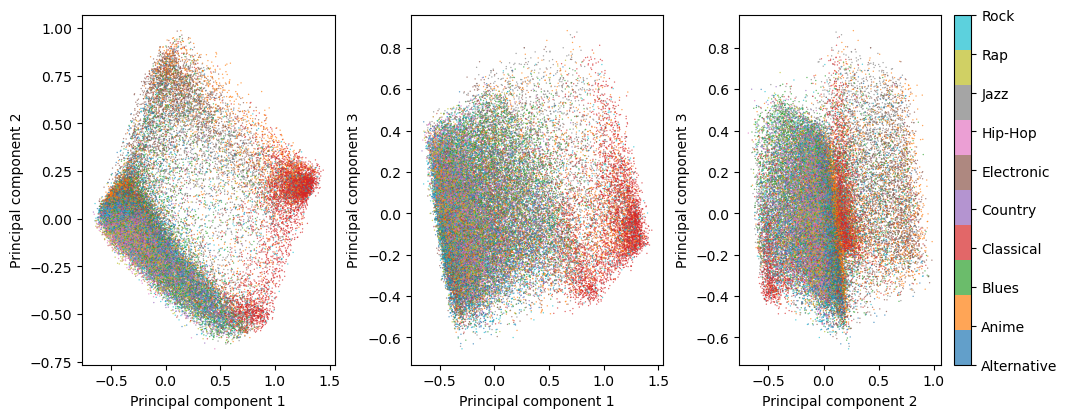

In [25]:
row_projection(projected_data, data_t_numerical)

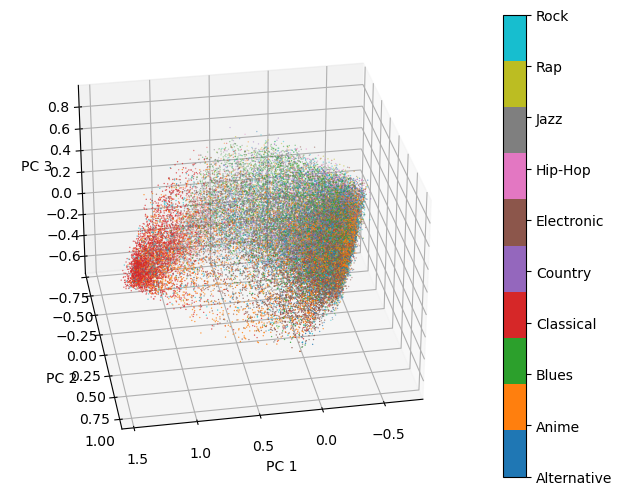

In [26]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(projection='3d')
cmap=plt.cm.get_cmap('tab10')
sc = ax.scatter(projected_data[:, 0], projected_data[:, 1], projected_data[:, 2], c=data_t_numerical["music_genre"], 
            edgecolor='none', cmap=cmap, vmin = 0, s=1)
col = plt.colorbar(sc, ticks=np.linspace(0, 9, 10))
col.ax.yaxis.set_major_formatter(ticker.FixedFormatter(genres_tags))
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
ax.view_init(30,80)
plt.show()

<div style="text-align: justify">
From the plot of the songs in the 3PC dimensional space we cannot appreciate the songs forming groups of their respective genre. The most remarkable aspect is the fact that we can clearly appreciate classical songs the furthest away from other songs, indicating that our model will have it easier to classify classical songs. For the remainder, it is difficult or even impossible to distinguish the others genres.

Now, we print the 3 main components for each features to see which are the most important features of our problem.

In [60]:
main_components = pd.DataFrame(abs( pca.components_ ), columns = data_t_no_genre_continuous.columns)
main_components.head()

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,valence
0,0.131574,0.624897,0.194734,0.007385,0.469940,0.466098,0.051288,0.212721,0.053980,0.255600
1,0.129280,0.466083,0.111097,0.010170,0.303132,0.803474,0.026976,0.039800,0.042231,0.109783
2,0.035624,0.221918,0.350816,0.010700,0.000314,0.291701,0.053368,0.026804,0.005539,0.858842


<div style="text-align: justify">
Therefore, looking at the variance kept by each principal component, we can deduct that the more relevants features are 'acousticness', 'energy', 'instrumentalness' and 'loudness'. And we can observe that liveness and duration_ms do not have as important effect in the variance, as we had deduced from the histograms.

<div style="text-align: justify">
As keeping 3 principal components did not help us visualize the separation in the music genres, we continued by reducing the problem to 4 dimmensions with PCA. However, it did not gave a better result (Appendix 2).

### LDA as an alternative to PCA

<div style="text-align: justify">
As an alternative to PCA, we apply linear discriminant analysis (LDA) to our dataset, which seems natural as our purpose is to visualize the separation between different classes. We want to emphasize that we apply LDA to the whole dataset and not training set as our purpose by applying LDA is not to use it as a model for classification, but rather to show a representation of our data and the separation between different target classes in a 3D displayable space.

In [28]:
lda = LinearDiscriminantAnalysis(n_components=3)

In [29]:
lda_data = lda.fit_transform(data_t_no_genre_continuous, data_t_categorical['music_genre']) #(without the genre column, only the target class (genre))

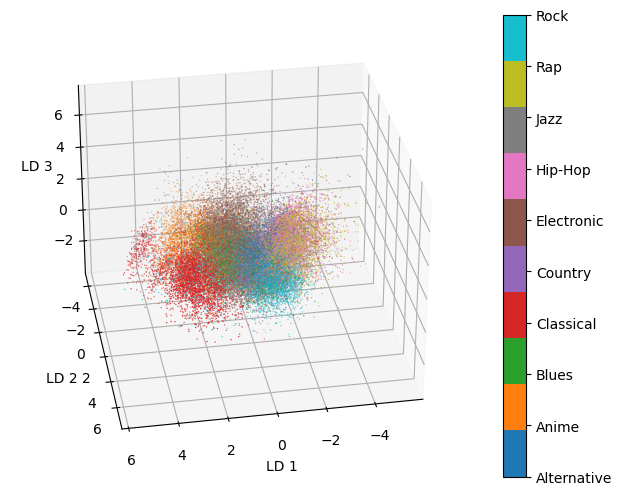

In [30]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(projection='3d')
cmap=plt.cm.get_cmap('tab10')
sc = ax.scatter(lda_data[:, 0], lda_data[:, 1], lda_data[:, 2], c = data_t_numerical["music_genre"], 
            edgecolor='none', cmap=cmap, s = 1)
col = plt.colorbar(sc, ticks=np.linspace(0, 9, 10))
col.ax.yaxis.set_major_formatter(ticker.FixedFormatter(genres_tags))
ax.set_xlabel('LD 1')
ax.set_ylabel('LD 2')
ax.set_zlabel('LD 3')
ax.view_init(30,80)
plt.show()

<div style="text-align: justify">
We obtain better results than with PCA, being able to observe in the 3 linear discriminant space how different songs are group by music genres. We can see again that Classical is the one the most differenciated from the rest. About the rest music genres it is hard to tell which ones are the most differenciated due to the large quantity of data in the plot that overlapping each other.  

**K-means clustering over the 3D produced by LDA**

<div style="text-align: justify">
Continuing with our study, we apply k-means clustering to the 3 dimmensions produced by the LDA. Once again, we are not intending to use it directly as a model for classification, as we will addresss this in the next section. However, we believe it interesting to explore the separation of the centroids produced by the k means clustering.    

In [116]:
kmeans = KMeans(len(np.unique(data_t_categorical['music_genre'])), random_state = 0)
kmeans.fit(lda_data)
centroids = kmeans.cluster_centers_

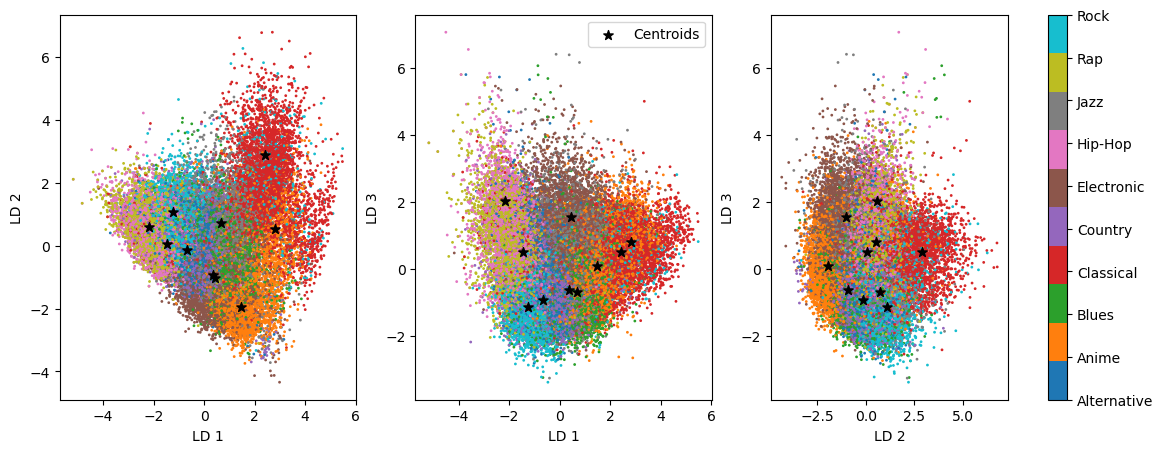

In [118]:
fig, axs = plt.subplots(1, 3, figsize = (13,5))
c_centroids = np.unique(data_t_numerical['music_genre'])

axs[0].scatter(lda_data[:, 0], lda_data[:, 1], c = data_t_numerical["music_genre"], cmap=cmap , s=1)
axs[0].scatter(centroids[:, 0], centroids[:, 1], c = "black" , marker='*', cmap = plt.cm.get_cmap('tab10'),
               edgecolor='black', s=50)
axs[0].set_xlabel('LD 1')
axs[0].set_ylabel('LD 2')

axs[1].scatter(lda_data[:, 0], lda_data[:, 2], c=data_t_numerical["music_genre"], cmap=cmap , s=1)
axs[1].scatter(centroids[:, 0], centroids[:, 2], c = "black" , marker='*',cmap = plt.cm.get_cmap('tab10'), 
               edgecolor='black', s=50, label='Centroids')
axs[1].set_xlabel('LD 1')
axs[1].set_ylabel('LD 3')
axs[1].legend()

sc = axs[2].scatter(lda_data[:, 1], lda_data[:, 2], c=data_t_numerical["music_genre"], cmap=cmap , s=1)
axs[2].scatter(centroids[:, 1], centroids[:, 2], c = "black" , marker='*',cmap = plt.cm.get_cmap('tab10'), 
               edgecolor='black', s=50)
axs[2].set_xlabel('LD 2')
axs[2].set_ylabel('LD 3')

col = plt.colorbar(sc, ticks=np.linspace(0, 9, 10), shrink=1, anchor=(1,0), pad=0.05, aspect=20)
col.ax.yaxis.set_major_formatter(ticker.FixedFormatter(genres_tags))
ax.view_init(30,80)
plt.show()

# 3. Classification models

<div style="text-align: justify">
As the models we consider for our study are of part of supervised learning it feels natural to rename the training and test dataframe to the general form (X_train, Y_train, X_test, Y_test). This will also make it easier for the readers to follow along.

In [209]:
X_train = data_t_no_genre_train
Y_train = data_t_categorical_train["music_genre"]
X_test = data_t_no_genre_test
Y_test = data_t_categorical_test["music_genre"]

In [210]:
#Fusion
X_train_f = data_t_no_genre_train_fusion
Y_train_f = data_t_categorical_train_fusion["music_genre"]
X_test_f = data_t_no_genre_test_fusion
Y_test_f = data_t_categorical_test_fusion["music_genre"]

## 3.1 Random Forest

In [214]:
def random_forest_implementation(classifier, X_train, Y_train, X_test, Y_test):
    classifier.fit(X_train, Y_train)
    Y_pred = classifier.predict(X_test)
    return Y_pred

**Classifier optimisation : hyper-parameters fine-tuning**

<div style="text-align: justify">
To optimize our random forest model we perform fine tuning of the hyperparameters via a randomized grid search that includes 5 cross validation.

In [215]:
def search_best_params(X_train, Y_train):
    param_grid = {
    'n_estimators': [200, 400, 500],
    'max_depth': [10, 20],
    'min_samples_split': [5, 10, 20],
    'min_samples_leaf': [1, 4],
    'max_features': ['auto']
    }
    grid_search = RandomizedSearchCV(estimator = RandomForestClassifier(), param_distributions = param_grid, cv = 5, n_jobs = -1, verbose = 1)
    grid_search.fit(X_train, Y_train)
    best_params = grid_search.best_params_
   
    max_depth = best_params['max_depth']
    max_features = best_params['max_features']
    min_samples_leaf = best_params['min_samples_leaf']
    min_samples_split = best_params['min_samples_split']
    n_estimators = best_params['n_estimators']
    
    return max_depth, max_features, min_samples_leaf, min_samples_split, n_estimators 

In [156]:
max_depth, max_features, min_samples_leaf, min_samples_split, n_estimators = search_best_params(X_train, Y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [157]:
classifier_bestparam = RandomForestClassifier(max_depth=max_depth, max_features = max_features,  
                                              min_samples_leaf= min_samples_leaf, 
                                              min_samples_split = min_samples_split, n_estimators = n_estimators)

In [158]:
Y_pred = random_forest_implementation(classifier_bestparam, X_train, Y_train, X_test, Y_test)

In [216]:
# Fusion
max_depth, max_features, min_samples_leaf, min_samples_split, n_estimators = search_best_params(X_train_f, Y_train_f)
classifier_bestparam_f = RandomForestClassifier(max_depth=max_depth, max_features = max_features,  
                                              min_samples_leaf= min_samples_leaf, 
                                              min_samples_split = min_samples_split, n_estimators = n_estimators)
Y_pred_f = random_forest_implementation(classifier_bestparam_f, X_train_f, Y_train_f, X_test_f, Y_test_f)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


C:\Users\USUARIO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\USUARIO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


**Analysis of the model**

<div style="text-align: justify">
We create the functions below to obtain metrics from the random forest model and be able to analyze its performance.

In [240]:
def classifier_scores(classifier, X_test, Y_test, Y_pred, genres_tags):
    report = classification_report(Y_test, Y_pred)
    feature_importances = classifier.feature_importances_
    predict_proba = classifier.predict_proba(X_test)
    roc_auc_value = roc_auc_score(Y_test, predict_proba, multi_class = "ovr")
    conf_matrix = confusion_matrix(Y_test, Y_pred, labels = genres_tags)
    return conf_matrix, report, feature_importances, predict_proba, roc_auc_value

In [221]:
def conf_matrix_plot(conf_matrix, genres_tags, fmt='d'):
    plt.figure()    
    sns.heatmap(conf_matrix, annot = True, fmt = fmt, cbar = True, xticklabels = genres_tags, yticklabels = genres_tags)

    plt.xticks(rotation = 90)
    plt.yticks(rotation = 0)
    plt.xlabel("Predicted values")
    plt.ylabel("True values")
    #plt.title(Title)
    plt.show()

In [105]:
def conf_matrix_row(fig, ax, conf_matrix1, conf_matrix2, genres_tags, fmt='d', suptitle= "Comparison of two confusions matrix",
                   title_1 = "", title_2 = ""):   
    
    sns.heatmap(conf_matrix1, annot = True, fmt = fmt, cbar = True, xticklabels = genres_tags, 
    yticklabels = genres_tags, ax=ax[0])
    ax[0].set_title(title_1)
    
    sns.heatmap(conf_matrix2, annot = True, fmt = fmt, cbar = True, xticklabels = genres_tags, 
    yticklabels = genres_tags, ax=ax[1])
    ax[1].set_title(title_2)
    
    plt.xticks(rotation = 90)
    plt.yticks(rotation = 0)
    fig.supxlabel('Predicted values')
    fig.supylabel('True values')
    plt.suptitle(suptitle)
    plt.show()

In [218]:
classifier_bestparam

RandomForestClassifier(max_depth=20, max_features='auto', min_samples_leaf=4,
                       min_samples_split=20, n_estimators=200)

In [171]:
conf_matrix, report, feature_importances, predict_proba, roc_auc_value = classifier_scores(classifier_bestparam, X_test, Y_test, Y_pred, genres_tags)

<div style="text-align: justify">
Precision is the number of well predicted genres of a class (True Positive) divided by all the times the model predicted that class (True positive + False Positive). So, if we have a precision of 0.8, when the model predict a genre, it is the good one around 80% of the time. 
For recall, it is a little different, it is the number of well predicted genres of a class (True Positive) divided by the number of elements in a genre (True Positive + False Negative). For all members of a genre, recall is how many we correctly identified.
The f1-score evaluate the performances of a model using precision and recall. 
    
    

In [172]:
print(report)

              precision    recall  f1-score   support

 Alternative       0.43      0.30      0.36       985
       Anime       0.72      0.66      0.69      1001
       Blues       0.56      0.45      0.50       988
   Classical       0.77      0.77      0.77      1042
     Country       0.50      0.52      0.51       989
  Electronic       0.60      0.56      0.58       970
     Hip-Hop       0.38      0.44      0.41       886
        Jazz       0.51      0.45      0.48      1065
         Rap       0.37      0.33      0.35       992
        Rock       0.43      0.72      0.54       962

    accuracy                           0.52      9880
   macro avg       0.52      0.52      0.52      9880
weighted avg       0.53      0.52      0.52      9880



In [241]:
# Fusion
conf_matrix_f, report_f, feature_importances_f, predict_proba_f, roc_auc_value_f = classifier_scores(classifier_bestparam, X_test_f, Y_test_f, Y_pred_f, genres_tags_fusion)
print(report_f)

                 precision    recall  f1-score   support

    Alternative       0.45      0.31      0.37      1019
          Anime       0.72      0.68      0.70       989
          Blues       0.58      0.47      0.52      1020
      Classical       0.76      0.75      0.75       975
        Country       0.54      0.52      0.53      1013
     Electronic       0.62      0.55      0.58       966
           Jazz       0.51      0.50      0.50       979
Rap and Hip-Hop       0.74      0.86      0.80      1914
           Rock       0.46      0.65      0.54      1005

       accuracy                           0.61      9880
      macro avg       0.60      0.59      0.59      9880
   weighted avg       0.61      0.61      0.61      9880



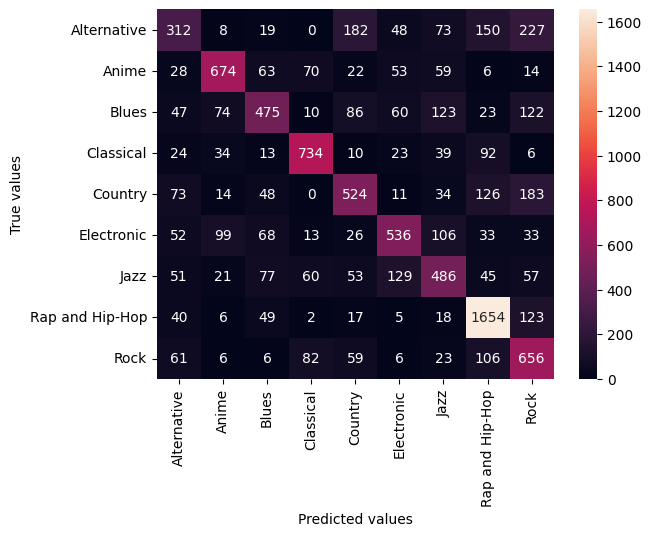

In [242]:
conf_matrix_plot(conf_matrix_f, genres_tags_fusion)

In [ ]:
#Fusion rock&alternative or erase alterantive 

<div style="text-align: justify">
So, we notice that classical has the higher precision and recall and so the higher f1-score, it is indeed the most identifiable genre. For Rock that has a relatively low precision but high recall, it means that it is difficult for the model to identify a Rock genre, but among the predicted rock genres, the most of them are actually rock.

<div style="text-align: justify">
Now we will inspect how much importance each feature for our random forest classifier.

In [173]:
feature_labels = data_t_no_genre.columns
feature_importances_df = pd.DataFrame({"Feature": feature_labels, "Importance": feature_importances})
feature_importances_df = feature_importances_df.sort_values(by = ["Importance"], ascending=False)

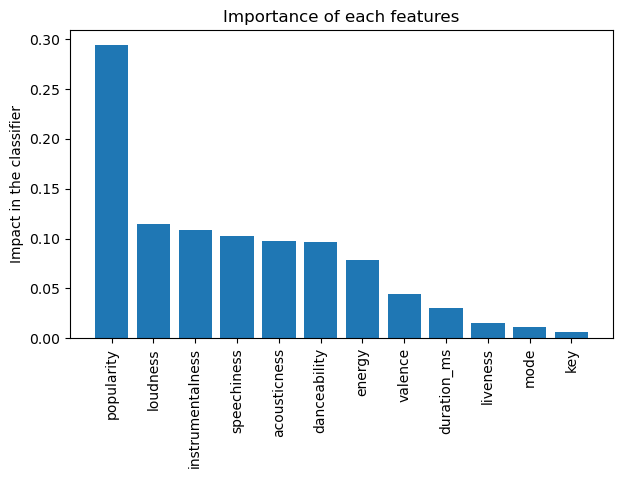

In [174]:
fig, ax = plt.subplots(figsize = (7,4))
ax.bar(feature_importances_df.iloc[:,0], feature_importances_df.iloc[:,1])
plt.title("Importance of each features")
plt.ylabel("Impact in the classifier")
plt.xticks(rotation = 90)
plt.show()

<div style="text-align: justify">
With this we can confirm that our initial hypothesis of the features "key", "mode" and "liveness" not being of substancial importance for the model was correct. To continue with, we will apply random forest to the dataset without these 3 features.

**Without key, mode and liveness**

In [76]:
X_train_no = X_train.drop(["key", "mode", "liveness"], axis = "columns")
X_test_no = X_test.drop(["key", "mode", "liveness"], axis = "columns")

In [176]:
max_depth, max_features, min_samples_leaf, min_samples_split, n_estimators = search_best_params(X_train_no, Y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [177]:
classifier_bestparam_no = RandomForestClassifier(max_depth=max_depth, max_features = max_features,  
                                              min_samples_leaf= min_samples_leaf, 
                                              min_samples_split = min_samples_split, n_estimators = n_estimators)

In [178]:
Y_pred_no = random_forest_implementation(classifier_bestparam_no, X_train_no, Y_train, X_test_no, Y_test)

In [179]:
conf_matrix_no, report_no, feature_importances_no, predict_proba_no, roc_auc_value_no = classifier_scores(classifier_bestparam_no, X_test_no, Y_test, Y_pred_no)

In [180]:
print(report_no)

              precision    recall  f1-score   support

 Alternative       0.42      0.31      0.36       985
       Anime       0.72      0.65      0.69      1001
       Blues       0.58      0.46      0.51       988
   Classical       0.77      0.76      0.77      1042
     Country       0.49      0.52      0.50       989
  Electronic       0.60      0.55      0.57       970
     Hip-Hop       0.38      0.42      0.40       886
        Jazz       0.50      0.46      0.48      1065
         Rap       0.37      0.36      0.36       992
        Rock       0.43      0.71      0.53       962

    accuracy                           0.52      9880
   macro avg       0.53      0.52      0.52      9880
weighted avg       0.53      0.52      0.52      9880



<div style="text-align: justify">
And as it was were expecting, the main metrics of performance of our model did not worsen.

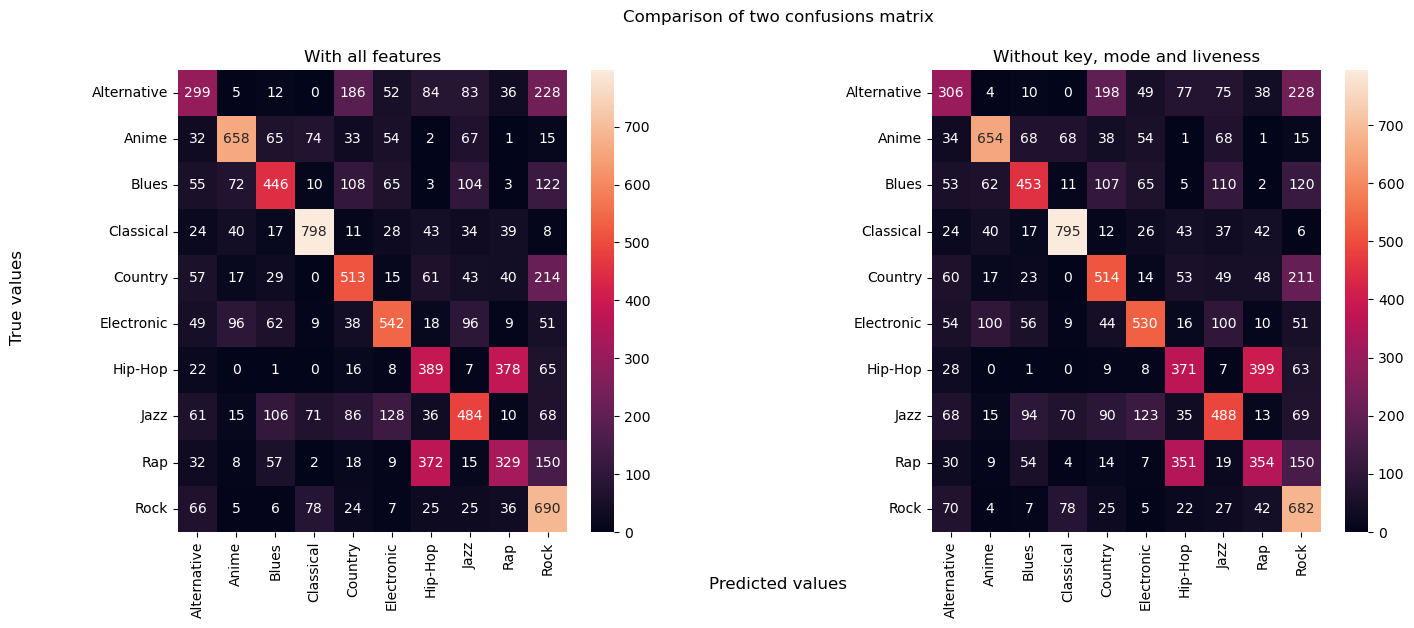

In [204]:
fig, ax = plt.subplots(1,2, figsize=(16,4))
fig.subplots_adjust(wspace = 0.55)
conf_matrix_row(fig, ax, conf_matrix, conf_matrix_no, genres_tags, title_1="With all features", 
                title_2="Without key, mode and liveness")

<div style="text-align: justify">
By analyzing the confusion matrix we can obtain the information provided by our metrics (accuracy, recall, precision) about which are the music genres our models correctly predicts best and which are the ones it mixes the most. As we can see comparing the two reports, even though there are light changes in the metrics for each music genre, the global metrics did not worsen after the removing of the 3 less important features.  

In [182]:
print(roc_auc_value_no)

0.8957658770807797


In [183]:
predict_proba_df =pd.DataFrame(predict_proba_no, columns = genres_tags)

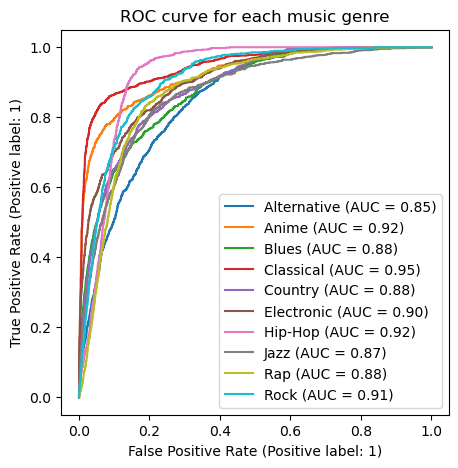

In [184]:
fig, ax = plt.subplots(figsize=(5, 5))
for genre in genres_tags:
    RocCurveDisplay.from_predictions(
        Y_test.eq(genre).astype(int), predict_proba_df[genre],
        ax=ax, name = genre, alpha = 1)
ax.set_title('ROC curve for each music genre')
ax.legend()
plt.show()


<div style="text-align: justify">
In general we can see high auc values for our music genres. However, we have to remember that the main aim was to classify songs by genre, not to classify whether a song belongs to a certain genre or not (binary classification). It is for this that we will explore how the random forest would perform on a binary classification problem for two good performing genres of the dataset, Classical and Rock. 

**Fusion rap and hip-hop"**

**Binary classification taking only "Rock" and "Classical"**

In [77]:
data_train_only_2 = data_t_categorical_train[(data_t_categorical_train["music_genre"] == "Rock") | (data_t_categorical_train["music_genre"] == "Classical")]
data_test_only_2 = data_t_categorical_test[(data_t_categorical_test["music_genre"] == "Rock") | (data_t_categorical_test["music_genre"] == "Classical")]

X_train_only_2 = data_train_only_2.iloc[:,:-1]
Y_train_only_2 = data_train_only_2["music_genre"]
X_test_only_2 = data_test_only_2.iloc[:,:-1]
Y_test_only_2 = data_test_only_2["music_genre"]

In [186]:
max_depth, max_features, min_samples_leaf, min_samples_split, n_estimators = search_best_params(X_train_only_2, Y_train_only_2)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [187]:
classifier_bestparam_only_2 = RandomForestClassifier(max_depth=max_depth, max_features = max_features,  
                                              min_samples_leaf= min_samples_leaf, 
                                              min_samples_split = min_samples_split, n_estimators = n_estimators)

In [188]:
Y_pred_only_2 = random_forest_implementation(classifier_bestparam_only_2, X_train_only_2, Y_train_only_2, X_test_only_2, Y_test_only_2)

In [189]:
report_only_2 = classification_report(Y_test_only_2, Y_pred_only_2)
feature_importances_only_2 = classifier_bestparam_only_2.feature_importances_

In [190]:
print(report_only_2)

              precision    recall  f1-score   support

   Classical       0.90      0.95      0.92      1042
        Rock       0.94      0.88      0.91       962

    accuracy                           0.92      2004
   macro avg       0.92      0.92      0.92      2004
weighted avg       0.92      0.92      0.92      2004



<div style="text-align: justify">
For a binary classification between Classical and Rock, the predictions are very accurate (92%). This is confirmed by the auc value and the roc_auc curves shown below.

In [191]:
predict_proba_only_2 = classifier_bestparam_only_2.predict_proba(X_test_only_2)
roc_auc_value = roc_auc_score(Y_test_only_2, predict_proba_only_2[:,1])
roc_auc_value

0.9423635580065524

In [208]:
predict_proba_df =pd.DataFrame(predict_proba_only_2, columns = ["Classical","Rock"])

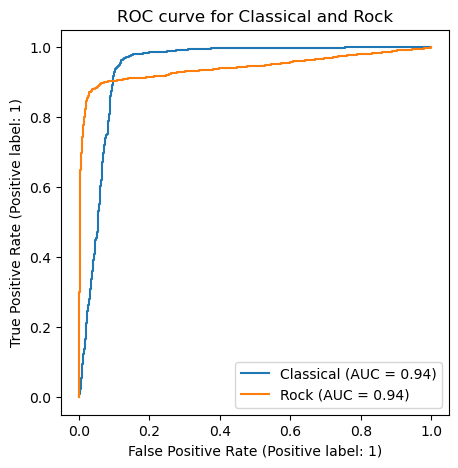

In [213]:
fig, ax = plt.subplots(figsize=(5, 5))
for genre in ["Classical", "Rock"]:
    RocCurveDisplay.from_predictions(
        Y_test_only_2.eq(genre).astype(int), predict_proba_df[genre],
        ax=ax, name = genre, alpha = 1)
ax.set_title('ROC curve for Classical and Rock')
ax.legend()
plt.show()

## 3.2 Neural Network

<div style="text-align: justify">
In this part we will build a neural network to see if it gives better results than the random forest model we presented before.

We start by one hot encoding our music genre target class. 

In [90]:
Y_train_oh = pd.get_dummies(data_t_numerical_train["music_genre"]) # one_hot data
Y_test_oh = pd.get_dummies(data_t_numerical_test["music_genre"])
Y_test_oh.head()

,0,1,2,3,4,5,6,7,8,9
0,0,0,0,0,0,0,1,0,0,0
1,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0
3,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1


<div style="text-align: justify">
For the architecture of our neural network we make it with 7 hidden layers apart from the input and output layers. We included dropout layers to prevent overfitting as without them the accuracy of the training set increased while the validation set did not. We used relu as the activation function except for the last one that we used softmax as we wanted to output a probability for each of the music genres.   

In [91]:
def neuronal_network(X_train, X_test, Y_train, Y_test, loss, epochs , input_shape, batch_size = 64, 
                     validation_split=0.2, output_shape = len(genres_tags)):
    model = keras.Sequential([
        keras.layers.Dense(128, activation='relu', input_shape=(input_shape,)),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(16, activation='relu'),
        keras.layers.Dense(10, activation='relu'),
        keras.layers.Dense(output_shape, activation='softmax') ])
    
    model.compile(optimizer='adam', loss=loss, metrics=["accuracy", "AUC"])
    history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_split = validation_split)
    
    ev = model.evaluate(X_test, Y_test)
    
    y_pred = model.predict(X_test)
    y_pred_index = np.argmax(y_pred, axis = 1)
    
    # On récupère ici l'indice (donc le genre) de la chanson
    Y_test_array = Y_test.to_numpy()
    max_indices = np.argmax(Y_test_array, axis=1)
    
    # We can plot thanks to this the confusion matrix
    conf_matrix = confusion_matrix(max_indices, y_pred_index)
    
    return model, history, y_pred_index, ev, max_indices, conf_matrix

In [92]:
def plot_metrics(history, model):   
    #plt.title(f"Using {model.loss} loss function")
    fig, ax = plt.subplots(1, 3, figsize = (15,3))
    fig.subplots_adjust(wspace = 0.25)
    
    ax[0].plot(history.history['loss'], label='training')
    ax[0].plot(history.history['val_loss'], label='validation')
    ax[0].set_xlabel('epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend()
    
    ax[1].plot(history.history['accuracy'], label='training')
    ax[1].plot(history.history['val_accuracy'], label='validation')
    ax[1].set_xlabel('epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()

    ax[2].plot(history.history['auc'], label='training')
    ax[2].plot(history.history['val_auc'], label='validation')
    ax[2].set_xlabel('epochs')
    ax[2].set_ylabel('Auc')
    ax[2].legend()

<div style="text-align: justify">
For the loss function we use categorical crossentropy which feels natural as our problematic is about classifying songs in different music genres. However, we also run the model with mse as the loss function and it did not make a difference in the results (Appendix 3).

In [93]:
model_2, history_2, y_pred_index_2, ev_2, max_indices_2, conf_matrix_2 = neuronal_network(X_train, X_test, Y_train_oh,
                                        Y_test_oh, loss = "categorical_crossentropy", epochs = 100, input_shape = 12)

Epoch 1/100
494/494 [==============================] - 3s 3ms/step - loss: 1.9361 - accuracy: 0.2722 - auc: 0.7585 - val_loss: 1.6581 - val_accuracy: 0.4114 - val_auc: 0.8405
Epoch 2/100
494/494 [==============================] - 1s 3ms/step - loss: 1.6364 - accuracy: 0.4049 - auc: 0.8432 - val_loss: 1.5297 - val_accuracy: 0.4459 - val_auc: 0.8644
Epoch 3/100
494/494 [==============================] - 1s 2ms/step - loss: 1.5682 - accuracy: 0.4313 - auc: 0.8572 - val_loss: 1.5078 - val_accuracy: 0.4582 - val_auc: 0.8685
Epoch 4/100
494/494 [==============================] - 1s 3ms/step - loss: 1.5370 - accuracy: 0.4476 - auc: 0.8631 - val_loss: 1.4895 - val_accuracy: 0.4607 - val_auc: 0.8715
Epoch 5/100
494/494 [==============================] - 1s 2ms/step - loss: 1.5112 - accuracy: 0.4584 - auc: 0.8678 - val_loss: 1.4920 - val_accuracy: 0.4661 - val_auc: 0.8708
Epoch 6/100
494/494 [==============================] - 1s 2ms/step - loss: 1.4973 - accuracy: 0.4649 - auc: 0.8705 - val_loss

494/494 [==============================] - 1s 2ms/step - loss: 1.3207 - accuracy: 0.5238 - auc: 0.9005 - val_loss: 1.3392 - val_accuracy: 0.5118 - val_auc: 0.8978
Epoch 94/100
494/494 [==============================] - 1s 2ms/step - loss: 1.3214 - accuracy: 0.5215 - auc: 0.9005 - val_loss: 1.3437 - val_accuracy: 0.5138 - val_auc: 0.8969
Epoch 95/100
494/494 [==============================] - 1s 2ms/step - loss: 1.3221 - accuracy: 0.5224 - auc: 0.9002 - val_loss: 1.3389 - val_accuracy: 0.5134 - val_auc: 0.8977
Epoch 96/100
494/494 [==============================] - 1s 2ms/step - loss: 1.3180 - accuracy: 0.5219 - auc: 0.9010 - val_loss: 1.3436 - val_accuracy: 0.5115 - val_auc: 0.8970
Epoch 97/100
494/494 [==============================] - 1s 2ms/step - loss: 1.3163 - accuracy: 0.5226 - auc: 0.9011 - val_loss: 1.3655 - val_accuracy: 0.5016 - val_auc: 0.8937
Epoch 98/100
494/494 [==============================] - 1s 2ms/step - loss: 1.3182 - accuracy: 0.5224 - auc: 0.9010 - val_loss: 1.346

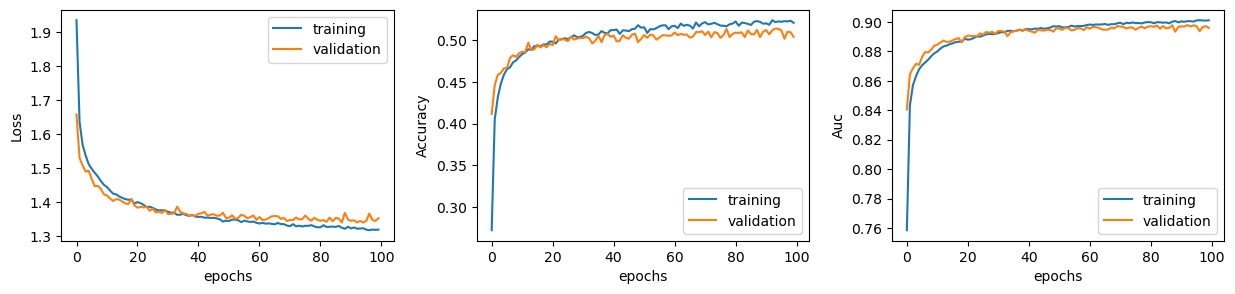

In [94]:
plot_metrics(history_2, model_2)

<div style="text-align: justify">
We observe that the validation loss decreases following the training loss, meaning we prevented overfitting and underfitting from the model training. This can also be confirmed regarding the constant increase in accuracy and auc metrics for both training and validation.

**Without key, mode and liveness**

We remove this 3 features

In [95]:
data_t_numerical_train_no = data_t_numerical_train.drop(["key", "mode", "liveness"], axis = "columns")
data_t_numerical_test_no = data_t_numerical_test.drop(["key", "mode", "liveness"], axis = "columns")

Y_train_oh_no = pd.get_dummies(data_t_numerical_train_no["music_genre"]) # one_hot data
Y_test_oh_no = pd.get_dummies(data_t_numerical_test_no["music_genre"])
Y_test_oh_no.head()

,0,1,2,3,4,5,6,7,8,9
0,0,0,0,0,0,0,1,0,0,0
1,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0
3,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1


In [98]:
model_no, history_no, y_pred_index_no, ev_no, max_indices_no, conf_matrix_no = neuronal_network(X_train_no, X_test_no, 
                                            Y_train_oh_no, Y_test_oh_no, loss = "categorical_crossentropy", epochs = 100, input_shape = 9)

Epoch 1/100
494/494 [==============================] - 2s 3ms/step - loss: 2.0279 - accuracy: 0.2572 - auc: 0.7179 - val_loss: 1.7650 - val_accuracy: 0.3697 - val_auc: 0.8179
Epoch 2/100
494/494 [==============================] - 1s 3ms/step - loss: 1.6895 - accuracy: 0.3853 - auc: 0.8327 - val_loss: 1.5880 - val_accuracy: 0.4106 - val_auc: 0.8535
Epoch 3/100
494/494 [==============================] - 1s 3ms/step - loss: 1.5995 - accuracy: 0.4213 - auc: 0.8513 - val_loss: 1.5411 - val_accuracy: 0.4460 - val_auc: 0.8622
Epoch 4/100
494/494 [==============================] - 1s 2ms/step - loss: 1.5526 - accuracy: 0.4404 - auc: 0.8606 - val_loss: 1.5347 - val_accuracy: 0.4537 - val_auc: 0.8629
Epoch 5/100
494/494 [==============================] - 1s 2ms/step - loss: 1.5216 - accuracy: 0.4522 - auc: 0.8664 - val_loss: 1.4975 - val_accuracy: 0.4612 - val_auc: 0.8700
Epoch 6/100
494/494 [==============================] - 1s 2ms/step - loss: 1.4987 - accuracy: 0.4644 - auc: 0.8704 - val_loss

494/494 [==============================] - 1s 2ms/step - loss: 1.3305 - accuracy: 0.5146 - auc: 0.8989 - val_loss: 1.3374 - val_accuracy: 0.5153 - val_auc: 0.8980
Epoch 94/100
494/494 [==============================] - 1s 2ms/step - loss: 1.3296 - accuracy: 0.5180 - auc: 0.8991 - val_loss: 1.3402 - val_accuracy: 0.5057 - val_auc: 0.8974
Epoch 95/100
494/494 [==============================] - 1s 2ms/step - loss: 1.3291 - accuracy: 0.5162 - auc: 0.8992 - val_loss: 1.3484 - val_accuracy: 0.5061 - val_auc: 0.8960
Epoch 96/100
494/494 [==============================] - 1s 2ms/step - loss: 1.3283 - accuracy: 0.5170 - auc: 0.8992 - val_loss: 1.3399 - val_accuracy: 0.5115 - val_auc: 0.8976
Epoch 97/100
494/494 [==============================] - 1s 2ms/step - loss: 1.3293 - accuracy: 0.5140 - auc: 0.8992 - val_loss: 1.3358 - val_accuracy: 0.5078 - val_auc: 0.8983
Epoch 98/100
494/494 [==============================] - 1s 2ms/step - loss: 1.3264 - accuracy: 0.5162 - auc: 0.8995 - val_loss: 1.334

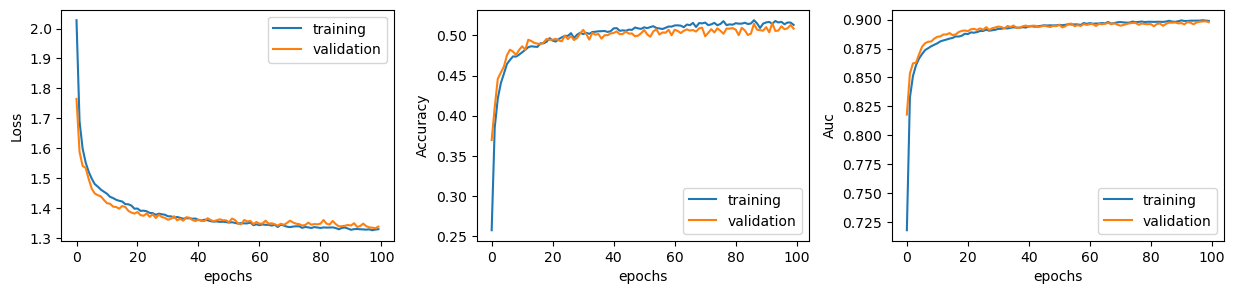

In [100]:
plot_metrics(history_no, model_no)

As we already saw in the random forest part, we are able to keep the same accuracy and auc score after removing the features key, mode and liveness.

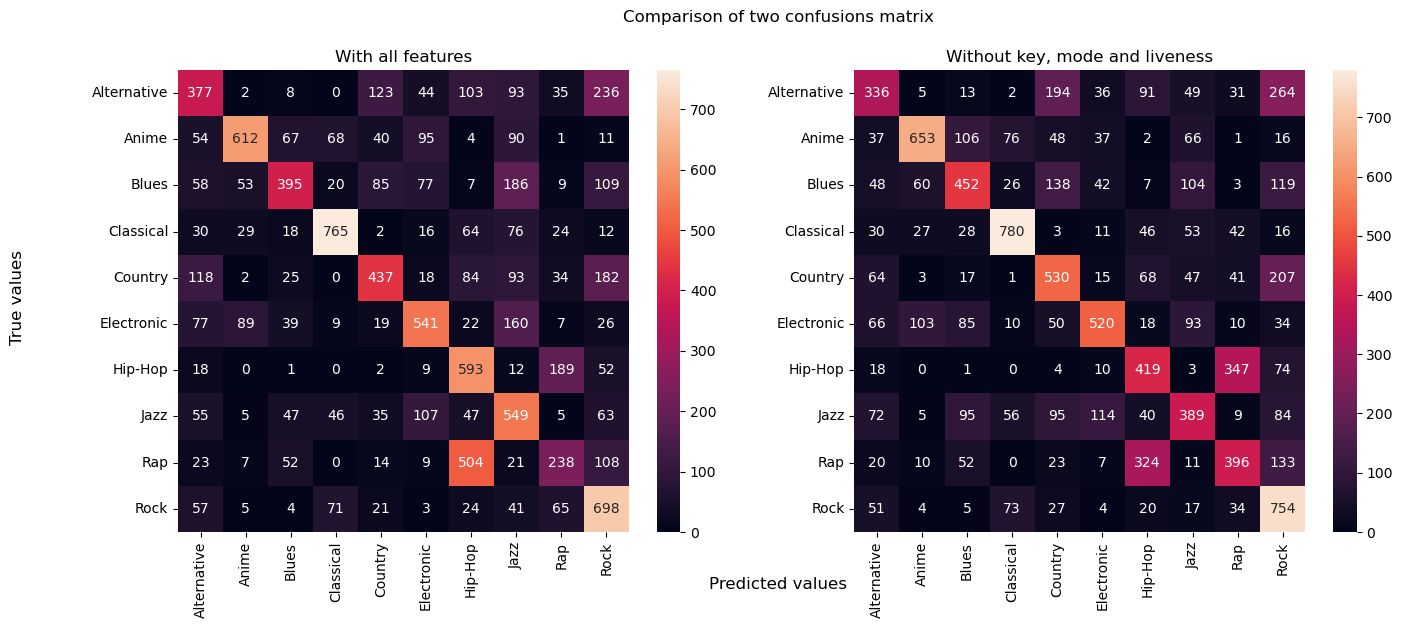

In [109]:
fig, ax = plt.subplots(1,2, figsize=(16,6))
conf_matrix_row(fig, ax, conf_matrix_2, conf_matrix_no, genres_tags, title_1="With all features", 
                title_2="Without key, mode and liveness")

<div style="text-align: justify">
Even though removing the less important features makes the accuracy, precision and recall slightly change for each genre, global metrics are equivalent.

**Binary classification taking only "Rock" and "Classical"**

In [78]:
Y_train_only_2_oh_no = pd.get_dummies(data_train_only_2["music_genre"]) # one_hot data
Y_test_only_2_oh_no = pd.get_dummies(data_test_only_2["music_genre"])
Y_test_only_2_oh_no.head()

,Classical,Rock
1,1,0
4,0,1
11,0,1
13,0,1
14,0,1


In [82]:
model_only_2, history_only_2, y_pred_index_only_2, ev_only_2, max_indices_only_2, conf_matrix_only_2 = neuronal_network(
    X_train_only_2, X_test_only_2, Y_train_only_2_oh_no, Y_test_only_2_oh_no, 
    loss = "categorical_crossentropy", epochs = 30, input_shape = 12, output_shape=2)

Epoch 1/30
100/100 [==============================] - 2s 5ms/step - loss: 0.4933 - accuracy: 0.8211 - auc: 0.8628 - val_loss: 0.4188 - val_accuracy: 0.8397 - val_auc: 0.8801
Epoch 2/30
100/100 [==============================] - 0s 3ms/step - loss: 0.3949 - accuracy: 0.8583 - auc: 0.8932 - val_loss: 0.3789 - val_accuracy: 0.8562 - val_auc: 0.9065
Epoch 3/30
100/100 [==============================] - 0s 3ms/step - loss: 0.3448 - accuracy: 0.8784 - auc: 0.9184 - val_loss: 0.3297 - val_accuracy: 0.8776 - val_auc: 0.9290
Epoch 4/30
100/100 [==============================] - 0s 3ms/step - loss: 0.3133 - accuracy: 0.8926 - auc: 0.9302 - val_loss: 0.3126 - val_accuracy: 0.8826 - val_auc: 0.9357
Epoch 5/30
100/100 [==============================] - 0s 3ms/step - loss: 0.2940 - accuracy: 0.8984 - auc: 0.9393 - val_loss: 0.3156 - val_accuracy: 0.8883 - val_auc: 0.9347
Epoch 6/30
100/100 [==============================] - 0s 3ms/step - loss: 0.2897 - accuracy: 0.9027 - auc: 0.9411 - val_loss: 0.31

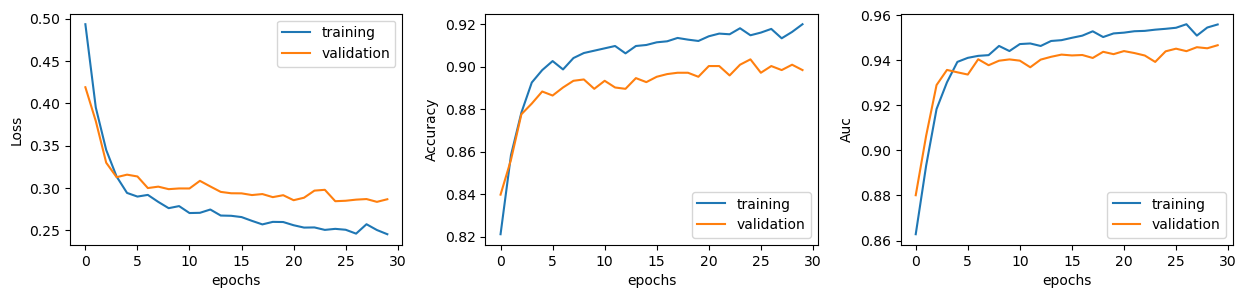

In [85]:
plot_metrics(history_only_2, model_only_2)

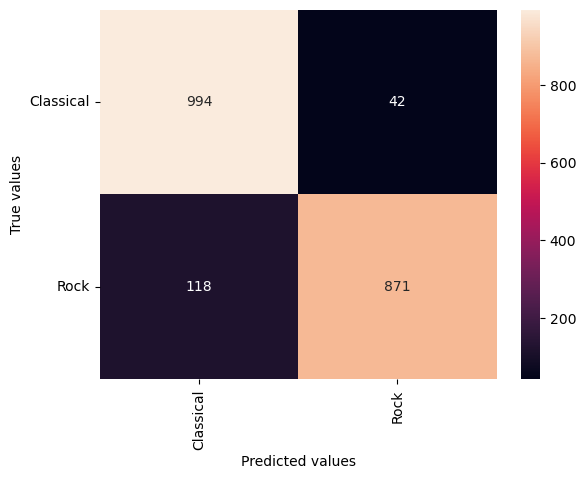

In [88]:
conf_matrix_plot(conf_matrix_only_2, ["Classical", "Rock"])

<div style="text-align: justify">
For only two genres (among the most different) the accuracy in the predictions is around 92%, similar result to the one we obtained with the random forest.

# Conclusion

<div style="text-align: justify">
    In this proyect, we explored the classification of music genres using machine learning techniques. We started by preprocessing the data, by removing id features, normalising the features, encoding categorical variables and splitting the dataset in training and test. We continued by exploring our data to obtain information about how it was distributed and which features were the most meaningful. For this we used PCA but since the visualization did not group songs by their genre we performed LDA, followed by k-means clustering (remark: to visualize and explore the nature of our data but not as classification models). <br> <br> 
For our classification model we considered a random forest and a neural network. For the first to optimize predictions we tuned the hyperparameters via randomgridsearch and for the neural network we included dropout layers and a validation split to prevent overfitting. We studied the impact of both models on the dataset having removed the less important features and observed the predictions did not worsen (accuracy ∼ 52%). To go further we studied the application on binary music genre classification and as we were expecting obtained much more accurate results in both models (accuracy ∼ 92%). <br><br>
We would like to note that despite having conducted feature engineering and optimisation of parameters we only achived around 52% accuracy in the classification of songs' music genre among 10 possible. This shows the difficulty in the task of music genre classification, which becomes easier as we reduce the number of possible music genres. 


# Bibliography

Apart from the slides from the course and the documentation from scikit learn we consulted the following websites: <br>
<br>
Miscellaneous: <br>
https://www.jeremyjordan.me/ml-projects-guide/ <br>
https://towardsdatascience.com/metrics-to-evaluate-your-machine-learning-algorithm-f10ba6e38234 <br>
https://machinelearningmastery.com/custom-metrics-deep-learning-keras-python/ <br>
https://www.hackerearth.com/practice/machine-learning/challenges-winning-approach/machine-learning-challenge-one/tutorial/ <br>
https://www.jeremyjordan.me/batch-normalization/ <br>
https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74 <br>
https://kobia.fr/classification-metrics-auc-roc/ <br>
https://www.youtube.com/@statquest <br>
<br>
PCA, LDA and K-means: <br>
https://www.geeksforgeeks.org/ml-linear-discriminant-analysis/ <br>
https://towardsdatascience.com/linear-discriminant-analysis-explained-f88be6c1e00b <br>
https://365datascience.com/tutorials/python-tutorials/pca-k-means/ <br>

Similar articles: <br>
https://www.researchgate.net/publication/362948512_Classification_of_Music_Genres_using_Feature_Selection_and_Hyperparameter_Tuning <br>
https://www.projectpro.io/article/music-genre-classification-project-python-code/566#mcetoc_1fsm03988d <br>

<div style="text-align: justify">


# APPENDIX

## Appendix 1

**Histogramms of features for genre**

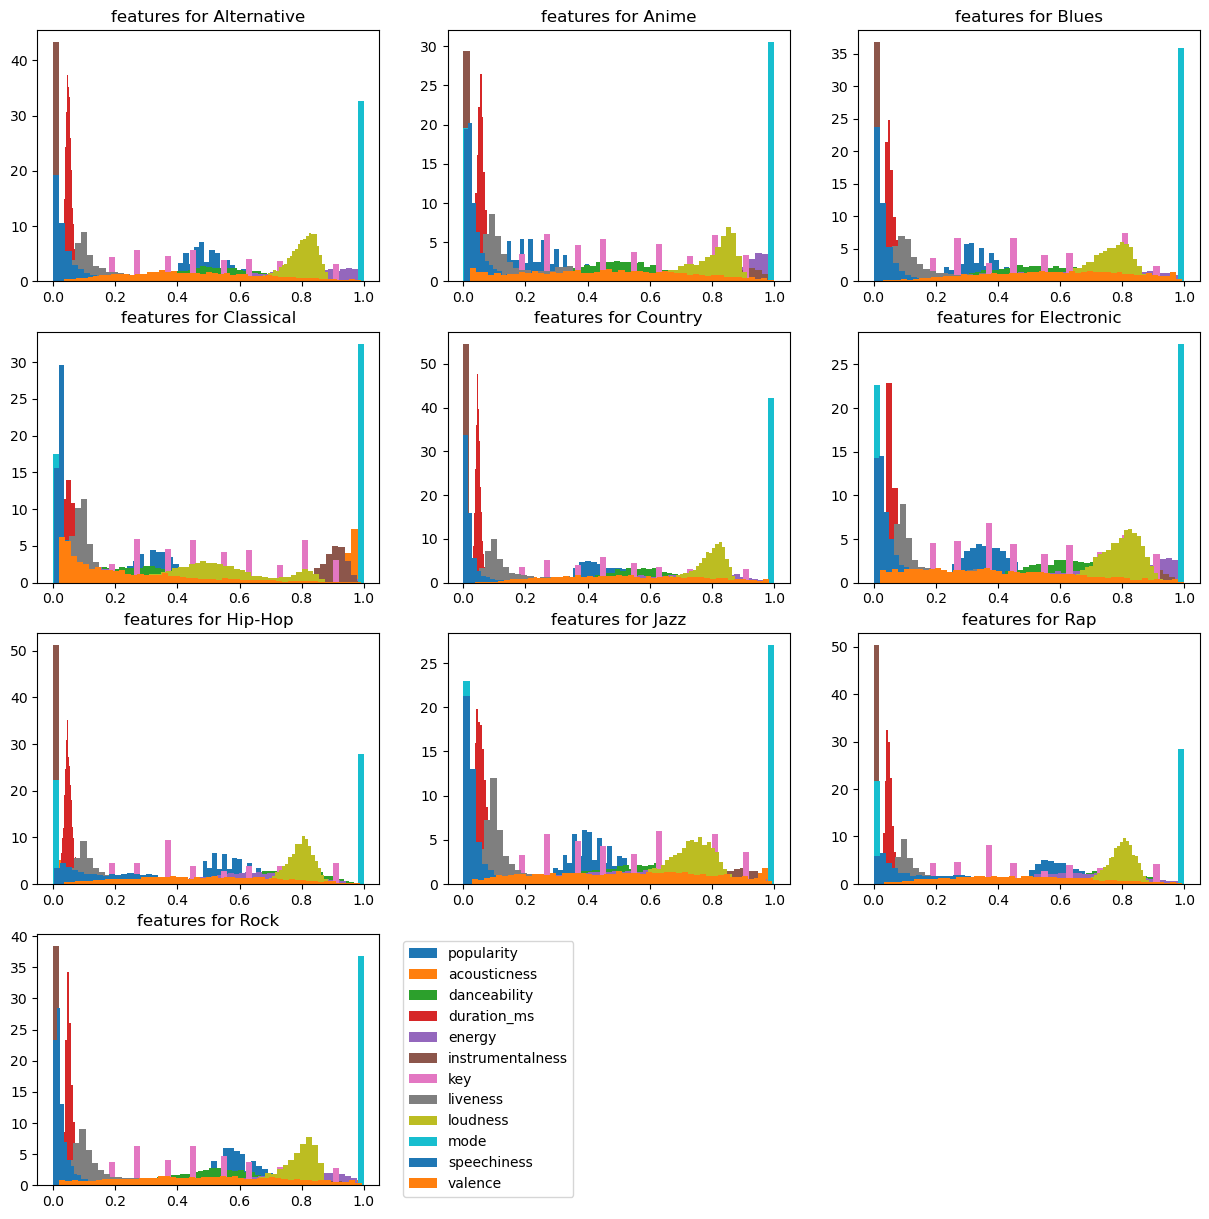

In [27]:
plt.figure(figsize=(15,15))
for i, genre in enumerate(genres_tags):
    plt.subplot(4,3,i+1)
    plt.title('features for ' + genre) 
    for feature in data_t_no_genre.columns:
        cond = data_t_categorical['music_genre'].values == genre
        dat_hist = data_t_numerical[cond]
        #print(f'{genre} : ', dat_hist.shape)
        plt.hist(dat_hist[feature], bins = 50, density=True, label = feature)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

# [:len(data_t_numerical)]

## Appendix 2

**We reduced the problem to a 4-dimensionnal problem with PCA**

In [235]:
pca4 =  PCA(n_components = 4)
projected_data4 =pca4.fit_transform(data_t_no_genre_continuous)
print(projected_data4.shape)

(49396, 4)


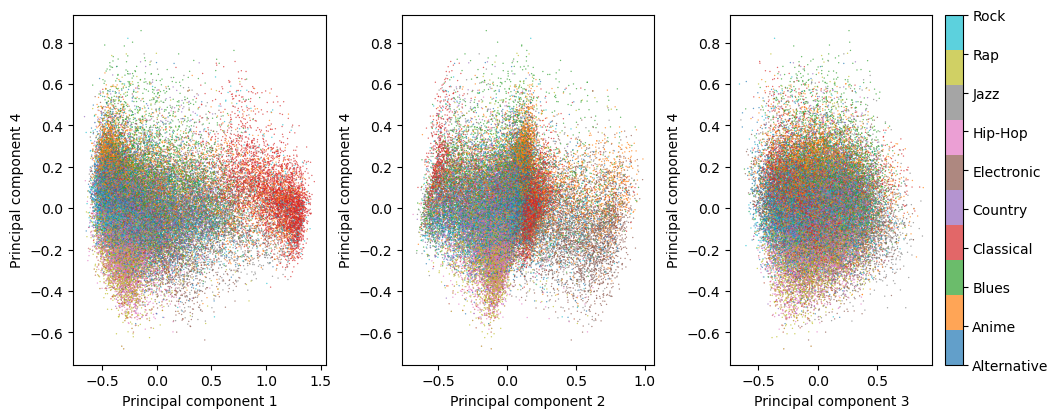

In [236]:
row_projection(projected_data4, data_t_numerical, ind00=0, ind01=3, ind10=1, ind11=3, ind20=2, ind21=3)

## Appendix 3

**Mse as loss function**

In [ ]:
model, history, y_pred_index, ev, max_indices, conf_matrix = neuronal_network(X_train, X_test, Y_train_oh, 
                                                                              Y_test_oh, loss = "mse", epochs = 100, input_shape = 12)

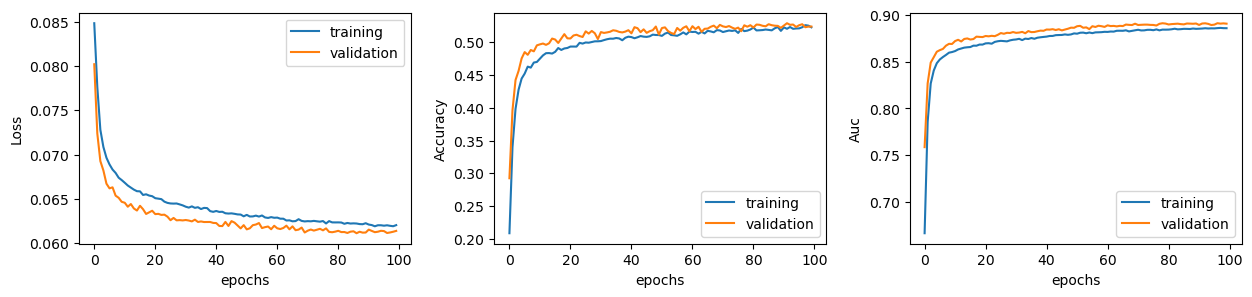

In [153]:
plot_metrics(history, model)